### Data Mining and Machine Learning

### Feature Selection in Supervised Classification

### Edgar Acuna

#### Febrero 2020

##### Use of modules: feature_selection from scikit-learn, feature selection from Arizona State University , skrebate and Orange 


In [23]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import math as m
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, SelectPercentile, f_classif, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Example 1: Diabetes dataset

In [115]:
url= "http://academic.uprm.edu/eacuna/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names,header=None)
y=data['class']
X=data.iloc[:,0:8]


### I. Feature Selection by Visualization using boxplots

In [116]:
print(data.shape)
data.head()
#normalizando los datos
data1=data.drop('class',axis=1)
data1_norm=(data1 - data1.min()) / (data1.max() - data1.min())
data1_norm['class']=data['class']

(768, 9)


<Figure size 720x3600 with 0 Axes>

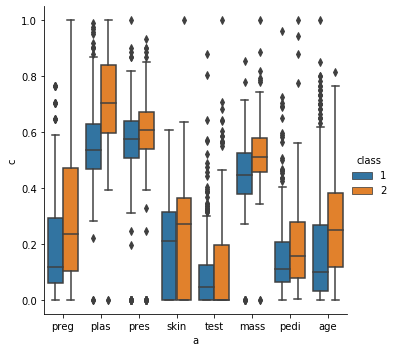

In [117]:
plt.figure(figsize=(10,50))
df_long = pd.melt(data1_norm, "class", var_name="a", value_name="c")
sns.factorplot("a", hue="class", y="c", data=df_long, kind="box")

Comment: From the boxplots we can see  that features: plas, age,preg,press and mass have boxplot not so overlaped

### II-Using the Chi-Square test  for choosing the best features
It is desirable to have discretized attributes and two classes. I do not recommend 
to use this method because the Chi-Square test is approximated and it is not robust.

In [118]:
y=data['class']
X=data.iloc[:,0:8]

In [119]:
# Funcion auxiliar para discretizar cualquier columna de un dataframe
def disc_col_ew(df,str,k,out):
    df1=df[str]
    bins=np.linspace(df1.min(), df1.max(),k)
    if out=="num":
        df1=pd.cut(df1,bins=bins,include_lowest=True, right=True,labels=False)
    else:
        bins[0]=float('-inf')
        bins[k-1]=float('inf')
        df1=pd.cut(df1,bins=bins,include_lowest=True, right=True)  
    return df1
# funcion auxiliar para determinar el numero optimo de intervalos segun la formula de scott
def nclass_scott(x):
    h=3.5*(np.var(x,ddof=1)**.5)*len(x)**(-.3333)
    intervals=m.ceil((max(x)-min(x))/h)
    return int(intervals)

In [120]:
#Funcion para discretizar todas las colunmnas de un dataframe
def disc_ew(df,out):
    name=df.columns.tolist()
    disc=pd.DataFrame()
    for name in df.columns.tolist():
        k=nclass_scott(df[name])
        disc[name]=disc_col_ew(df,name,k,out)
    return disc

In [121]:
#discretizando las columnas de la matriz predictora X de diabetes
diab_disc=disc_ew(X,out="num")

In [122]:
#Choosing the best features with Chi-square and scikit-learn
y1=y.as_matrix()
X1=diab_disc.as_matrix()
test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X1, y1)
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
features= fit.transform(X1)
# Imprime los datos de las tres mejores features
print(features)

[105.387 120.206   2.87   10.086  59.232  42.746  62.639 115.924]
[[ 4 11  6]
 [ 0  6  2]
 [ 6 14  2]
 ...
 [ 3  9  1]
 [ 0 10  5]
 [ 0  7  0]]


Comentario: Las tres mejores variables con la prueba de Chi-square son plas, age y preg por tener el Chi-Square mas alto.

### III-Using the F test to find the best features  

Se puede usar la libreria sciki-learn o la libreria de la ASU

In [123]:
# Selecion  de Features usando los p-values de la F-test como score
# Aqui usamos scikit-learn y se selecciona el 30% de deatures con el mas alto score
selector = SelectPercentile(f_classif, percentile=30)
fit=selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
print(scores)
features= fit.transform(X)
# Imprime los datos de las tres mejores features
print(features)

[0.221 1.    0.027 0.034 0.084 0.378 0.14  0.253]
[[148.   33.6  50. ]
 [ 85.   26.6  31. ]
 [183.   23.3  32. ]
 ...
 [121.   26.2  30. ]
 [126.   30.1  47. ]
 [ 93.   30.4  23. ]]


Comentario: Las tres, mejores variables con la prueba de F son plas,mass y age

In [124]:
#Usando la libreria Feature selection de la ASU
#features, labels = X.values, data['class'].values
#X_train, X_test, y_train, y_test = train_test_split(features, labels)
from skfeature.function.statistical_based import f_score
scoref = f_score.f_score(X, y)
idx = f_score.feature_ranking(scoref)
print(scoref,idx)

[ 39.67  213.162   3.257   4.304  13.281  71.772  23.871  46.141] [1 5 7 0 6 4 3 2]


Comentario: las tres variables mas importantes con la prueba de F son: plas,mass y age

### IV- Usando Mutual Information (Entropia)

Usando el modulo  scikit-learn


In [125]:
# Univariate feature selection with Mutual Information
scores = mutual_info_classif(X,y)
scores /= scores.max()
print(scores)

[0.657 1.    0.236 0.231 0.37  0.526 0.099 0.466]



Comentario: Las tres variables usando el criterio de Mutual Information son: plas, mass y age

### V-Using ReliefF to select the best features 

#### Usando el modulo skrebate 

In [126]:
from skrebate import ReliefF

df=data.drop('class',axis=1)
#Normalizando las predictoras
df_norm=(df - df.min()) / (df.max() - df.min())
features, labels = df_norm.values, data['class'].values

In [127]:
fs = ReliefF(n_neighbors=10)
fs.fit(features, labels)
for feature_name, feature_score in zip(data.columns,fs.feature_importances_):
    print (feature_name, feature_score)

preg 0.011557904411764679
plas 0.027526957705192593
pres 0.005626707650273222
skin 0.012511837121212118
test 0.004258551270685579
mass 0.015538065076999513
pedi 0.007962389695417026
age 0.009900173611111106


Comentario: las tres variables mas importantes con el ReliefF son: plas,mass y skin

#### ReliefF using the feature selection module form the ASU

In [128]:
from skfeature.function.similarity_based import reliefF
y1=y.as_matrix()
X1=X.as_matrix()
score_relief=reliefF.reliefF(X1,y1)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

[ 230.6   2752.6    521.8    875.4   1389.8    674.06    20.236  891.6  ] [1 4 7 3 5 2 0 6]


 Comentario: las tres variables mas importantes con el RelieF son: plas, test y age
 

#### Usando el Relief de Orange

In [42]:
import Orange
df = Orange.data.Table("https://academic.uprm.edu/eacuna/diabetes.tab")
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=100 para updating de los pesos
print('Feature scores for best  features (scored individually):')
meas =Orange.preprocess.score.ReliefF(n_iterations=400,k_nearest=10)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)

Feature scores for best  features (scored individually):
0.015 preg
0.029 plas
0.008 pres
0.017 skin
0.006 test
0.015 mass
0.011 pedi
0.010 age


In [45]:
#ordenando los scores
import scipy.stats as ss
ss.rankdata(scores)

array([6., 8., 2., 7., 1., 5., 4., 3.])

The best features are: plas, mass and skin.

### Example 2:  Bupa dataset
####  Usando el reliefF de la ASU

In [130]:
#load data
url= "http://academic.uprm.edu/eacuna/bupa.dat"
names = ['mcv', 'alkphos', 'sgpt', 'aspar', 'gammagt', 'drinks', 'class']
data = pd.read_table(url, names=names,header=None)
y=data['class']
X=data.iloc[:,0:6]
y1=y.as_matrix()
X1=X.as_matrix()
features, labels = X.values, data['class'].values

In [131]:
score_relief=reliefF.reliefF(X1,y1)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

[ 48.4  78.2 276.2 142.2 209.6  90.5] [2 4 3 5 1 0]


El Relief de ASU recomienda sgpt, gammagt,aspar  como las mejores predictoras

In [132]:
#Aplicando MRMR a Bupa
from skfeature.function.information_theoretical_based import MRMR
MRMR.mrmr(X1,y1)

(array([4, 5], dtype=int64), array([ 0.285, -1.499]), array([0.285, 0.085]))

#### Usando skrebate

In [133]:
df=data.drop('class',axis=1)
#Normalizando las predictoras
df_norm=(df - df.min()) / (df.max() - df.min())
features, labels = df_norm.values, data['class'].values

In [134]:
fs = ReliefF(n_neighbors=10)
fs.fit(features, labels)
for feature_name, feature_score in zip(data.columns,fs.feature_importances_):
    print (feature_name, feature_score)

mcv 0.0028375286041189907
alkphos -0.0006200378071833658
sgpt 0.005445820136289467
aspar 0.0033427442123094295
gammagt 0.004875918205280923
drinks 0.00485507246376812


El relielf de skrebate recomienda gammagt, aspar and sgpt 

### Example 3: Breast-cancer-Wisconsin

In [135]:
data = pd.read_table("https://academic.uprm.edu/eacuna/breast-cancer-wisconsin.data", header=None,sep=",",na_values="?")
data=data.fillna(data.mean())
y=data.iloc[:,10]
X=data.iloc[:,1:10]
y1=y.as_matrix()
X1=X.as_matrix()
features, labels = X.values, y.values
X_train, X_test, y_train, y_test = train_test_split(features, labels)

In [136]:
#usando Relief de la ASU
score_relief=reliefF.reliefF(X1,y1)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

[1338.2    806.4    789.6    677.2    404.2   1558.917  695.6    831.
  317.8  ] [5 0 7 1 2 6 3 4 8]


In [137]:
#Usando el Relief de Orange
import Orange
df = Orange.data.Table("https://academic.uprm.edu/eacuna/breast-cancer-wisconsin.tab")
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=400 para updating de los pesos
print('Feature scores for best ten features (scored individually):')
meas =Orange.preprocess.score.ReliefF(n_iterations=500,k_nearest=1)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)


Feature scores for best ten features (scored individually):
0.594 Clump
0.202 Unif_Cell_Size
0.144 Unif_Cell_Shape
0.138 Marginal_Adh
0.184 Single_Cell_Size
0.626 Bare_Nuclei
0.498 Bland_Chromatine
0.374 Normal_Nucleoi
0.072 Mitoses


Comment:The best attributes are:6(Bare Nuclei),1 (Clump Thickness),7 (Bland Chromatin), 8 (Normal. nucleoli)

#### Example 4: Landsat Dataset

In [138]:
url='http://academic.uprm.edu/eacuna/landsat.txt'
data = pd.read_table(url, header=None,delim_whitespace=True)
y=data.iloc[:,36]
X=data.iloc[:,0:36]
y1=y.as_matrix()
X1=X.as_matrix()
features, labels = X.values, y.values
X_train, X_test, y_train, y_test = train_test_split(features, labels)

### Using Relief from skfeature (ASU)

In [139]:
#usando Relief de la ASU
score_relief=reliefF.reliefF(X_train,y_train)
feat=reliefF.feature_ranking(score_relief)
print(score_relief,feat)

[ 931636.234 1216621.087  909452.239 1070887.622  910440.181 1189498.725
  846666.128 1010719.061  964074.186 1310465.23   879559.2   1179786.713
  964872.263 1207983.863  892047.358 1043522.992  958125.393 1268029.906
  828836.112  979570.384 1013115.129 1378438.876  772365.01  1037983.834
  972448.599 1269092.132  861762.414 1021571.341  926200.25  1287428.774
  798108.402  962734.645  973067.76  1389337.658  832095.578 1080186.072] [33 21  9 29 25 17  1 13  5 11 35  3 15 23 27 20  7 19 32 24 12  8 31 16
  0 28  4  2 14 10 26  6 34 18 30 22]


Comment:The best attributes are:26,14,34,22,30,2,10,18,6,28

### Using Relief from Orange

In [49]:
#Usando el Relief de Orange
import Orange
df = Orange.data.Table("https://academic.uprm.edu/eacuna/landsat.tab")
print('Feature scores  (scored individually):')
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=3000 para updating de los pesos
meas =Orange.preprocess.score.ReliefF(n_iterations=3000,k_nearest=10)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)


Feature scores for best ten features (scored individually):
0.113 a1
0.087 a2
0.076 a3
0.067 a4
0.112 a5
0.076 a6
0.056 a7
0.058 a8
0.108 a9
0.085 a10
0.056 a11
0.066 a12
0.126 a13
0.100 a14
0.074 a15
0.077 a16
0.122 a17
0.097 a18
0.073 a19
0.067 a20
0.118 a21
0.091 a22
0.059 a23
0.068 a24
0.123 a25
0.097 a26
0.077 a27
0.072 a28
0.116 a29
0.096 a30
0.064 a31
0.063 a32
0.117 a33
0.091 a34
0.063 a35
0.067 a36


In [51]:
#ordenando los scores
ss.rankdata(scores)

array([30., 21., 16.,  9., 29., 17.,  1.,  3., 28., 20.,  2.,  8., 36.,
       27., 15., 18., 34., 25., 14., 10., 33., 23.,  4., 12., 35., 26.,
       19., 13., 31., 24.,  7.,  5., 32., 22.,  6., 11.])

Comment:The best attributes are:a13,a25,a17,a21,a33,a29,a1,a5,a9

### Feature selection using Minumum Redudancy and Maximum Relevancy (MRMR) 

In [141]:
#Aplicandolo a Landsat
from skfeature.function.information_theoretical_based import MRMR
MRMR.mrmr(X1,y1)

(array([17, 24], dtype=int64), array([ 1.194, -0.702]), array([1.194, 0.983]))

### Applying Relief to a dataset with mixed tyoe of attributes

In [8]:
import Orange
df = Orange.data.Table("https://academic.uprm.edu/eacuna/loan.tab")
df

[[Hombre, 3, No, 17, 2500, ... | No],
 [Mujer, 5, Si, 10, 3000, ... | Si],
 [Mujer, 4, No, 15, 2000, ... | No],
 [Hombre, 3, Si, 16, 2800, ... | Si],
 [Hombre, 6, Si, 11, 4000, ... | Si],
 ...
]

In [143]:
meas =Orange.preprocess.score.ReliefF(n_iterations=2000,k_nearest=10)
scores = meas(df)

In [144]:
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)

0.088 Sexo
-0.007 Familia
0.025 CasPropia
0.018 AnosEmpleo
0.063 Sueldo
0.130 StatustMarital


In [52]:
#Usando el Relief de Orange
import Orange
df = Orange.data.Table("https://academic.uprm.edu/eacuna/heart_disease.tab")
print('Feature scores (scored individually):')
#ReliefF usando 10 vecinos mas cercanos y  una muestrd m=200 ara updating de los pesos
meas =Orange.preprocess.score.ReliefF(n_iterations=200,k_nearest=10)
scores = meas(df)
for attr, score in zip(df.domain.attributes, scores):
    print('%.3f' % score, attr.name)


Feature scores (scored individually):
0.012 age
0.093 gender
0.178 chest pain
0.018 rest SBP
-0.003 cholesterol
0.019 fasting blood sugar > 120
0.073 rest ECG
0.016 max HR
0.060 exerc ind ang
0.022 ST by exercise
0.046 slope peak exc ST
0.098 major vessels colored
0.151 thal


In [53]:
#ordenando los scores
ss.rankdata(scores)

array([ 2., 10., 13.,  4.,  1.,  5.,  9.,  3.,  8.,  6.,  7., 11., 12.])

The best features are: chest pain, thal, major vessels colored, gender